<a href="https://colab.research.google.com/github/ramstar3000/SkinDetection/blob/main/debug/CNN_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from google.colab import files,output
from tqdm import tqdm
import matplotlib.pyplot as plt

from random import randint
from cv2 import warpAffine, getRotationMatrix2D, resize

%ls

sample_data/


In [ ]:
! pip install -q kaggle
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

import kaggle

! kaggle datasets download -d ramstar3000/ham10000
! mkdir Images
! unzip ham10000.zip -d Images
output.clear()

%ls

In [ ]:
def rotation(image): # Image array

  image = (image.astype(np.uint8)).reshape(28,28,3)

  i = randint(0,15)
  height, width = image.shape[:2]
  center = (28/2, 28/2)
  # print(center)
  #print(image.shape)
  image = warpAffine(src=image, M=getRotationMatrix2D(center=center, angle=i, scale=1) , dsize=(width, height))

  newImage = resize(image, (28, 28))

  image = (newImage.astype(np.float64)).reshape(2352,)

  return image

In [ ]:
def stratify_img_matrix():
    csv = pd.read_csv('Images/out.csv')   #/content/Images/hmnist_28_28_RGB.csv

    _ = np.array(pd.DataFrame(csv))

    print(_.shape)

    for row in _:
      #print(row[-1])
      #print(1)
      if row[-1] != 4 and row[-1] != 6 and row[-1] != 2:
        label = row[-1]
        new = rotation(row[:-1])
        new = np.append(new,int(label))

        #print(new.shape)
        assert new[-1] == label

        #print(_.shape)
        #print(new.shape)

        _ = np.vstack([_, new])

        #_ = np.append(_,new,axis=0)


    print(_.shape)

    csv = pd.DataFrame(_)

    column_names = list(range(2352))
    column_names.append('label')
    csv.columns = column_names


    from pathlib import Path
    filepath = Path('Images/out2.csv')
    #filepath.parent.mkdir(parents=True, exist_ok=True)
    csv.to_csv(filepath, header=False, index=False)


#stratify_img_matrix()

In [ ]:
def get_img_matrix():

    csv = pd.read_csv('Images/out2.csv')   #/content/Images/hmnist_28_28_RGB.csv

    #print(csv)
    #csv = pd.DataFrame(_)

    column_names = list(range(1,2353))
    column_names.append('label')
    csv.columns = column_names



    y = csv['label']

    #csv['label'].value_counts().plot(kind='bar')

    df = pd.DataFrame(y)


    X = csv.drop(columns = ['label'])
    X = (np.array(X).reshape(-1,28*28*3)) # 3d as 3 channels, -1 refers to orig of 10005


    #Now do rotating nonsesne


    return X[:-1],y[:-1]


#g = get_img_matrix()

In [ ]:
from sklearn.model_selection import train_test_split
def split(X,y):

  return train_test_split(
      X, y, test_size=0.2, random_state=2)   #Start with random split, should do stratified?


In [ ]:
def nanargmax(arr):
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape) #Get index as multi dimension
    return idxs

In [ ]:
def init_filter(shape):
    stddev = 1 / np.sqrt(np.prod(shape))   # STDDEV used to give rough scale to values
    return np.random.normal(loc=0, scale=stddev, size=shape)

In [ ]:
def init_weights(shape):
    return np.random.normal(size=shape) * 0.01

In [ ]:
def relu(array):
    array[array<=0] = 0
    return array

In [ ]:
def convolution(image, filt, bias, s=1):

    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    n_c, in_dim, _ = image.shape # image dimensions

    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions some mad formula ting

    # Dimensions of filter must match channels of input image

    out = np.zeros((n_f,out_dim,out_dim))   #If 8 filters, 8 dimensions(1) provided

    # convolve the filter over every part of the image, adding the bias at each step.
    #Need to look over and adjust
    for curr_f in range(n_f):
        curr_y = out_y = 0
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            while curr_x + f <= in_dim:
                #print(curr_f)
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s #Slide across
                out_x += 1  #Move into next location for output
            curr_y += s  #Slide down
            out_y += 1   #Move 1

    return out


def convolutionBackward(dconv_prev, conv_in, filt, s): #Analyse

    #Backpropagation through a convolutional layer.

    (n_f, n_c, f, _) = filt.shape
    (_a, orig_dim, _b) = conv_in.shape

    #assert _ == _b

    ## initialize derivatives
    dout = np.zeros(conv_in.shape)
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])

    return dout, dfilt, dbias



In [ ]:
def maxpool(image, f=2, s=2):

    #Downsample image using size of f and stride of s

    try:
      n_c, h_prev, w_prev = image.shape #Get old/current dimensions
    except:
      h_prev, w_prev = image.shape
      n_c = 1

    h = ((h_prev - f)/s)+1  #Calculate new dimensions of img
    w = ((w_prev - f)/s)+1  #Int been moved so beware int((h_prev - f)/s)+1

    #print(image)
    #print(image[0, 0:2, 4:6])  #[channel num, x:x+2 , y:y+2], is a 2x2 grid


    output = np.zeros((n_c, int(h), int(w)))  #Make empty array to be filled

    for i in range(n_c): #Once for each channel
        # slide maxpool window over each part of the image and assign the max value at each step to the output
        curr_y = out_y = 0     #Initialised
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:  #Only runs till reaches end of line
                output[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s  #Slide across
                out_x += 1   #Next index in final array
            curr_y += s    #Slide down
            out_y += 1     #Move into next index downwards

    return output

def maxpoolBackward(dpool, orig, f, s): #Analyse

    #Backpropagation through a maxpooling
    # Gradients are passed through the indices of greatest value in the original maxpooling during the forward step.

    (n_c, orig_dim, _) = orig.shape
    dout = np.zeros(orig.shape)

    #print(orig)

    for c in range(n_c):   #Once for each channel
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window

                (a, b) = nanargmax(orig[c, curr_y:curr_y+f, curr_x:curr_x+f])
                dout[c, curr_y+a, curr_x+b] = dpool[c, out_y, out_x]

                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1

    #print(dout)


    return dout

In [ ]:
def softmax(X):
    out = np.exp(X)
    return out/np.sum(out)

def categoricalCrossEntropy(probs, label):
    return -np.sum(label * np.log(probs))

In [ ]:
def conv(image, label, params, conv_s, pool_f, pool_s):  #1#1#1# Analyse backward, also may be broken

    [f1, f2, w3, w4, b1, b2, b3, b4] = params

    ##############     Forward       ###############

    conv1 = convolution(image, f1, b1, conv_s) # convolution
    conv1 = relu(conv1) # pass through ReLU non-linearity

    conv2 = convolution(conv1, f2, b2, conv_s) # second convolution
    conv2 = relu(conv2) # pass through ReLU non-linearity
    #print(conv2.shape)

    pooled = maxpool(conv2, pool_f, pool_s) # maxpooling

    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1)) # flatten
    #print(fc.shape)

    z = w3.dot(fc) + b3 # first dense layer
    z = relu(z) # pass through ReLU non-linearity

    out = w4.dot(z) + b4 # second dense layer

    probs = softmax(out) # predict class probabilities with the softmax activation function
    #print(probs)

    #Calculate Loss (Loss function is for batch, cost for multiple)
    loss = categoricalCrossEntropy(probs, label) # categorical cross-entropy loss

    #############      Backward      ###############

    dout = probs - label # (7,)   derivative of loss w.r.t. final dense layer output
    dw4 = dout.dot(z.T) # loss gradient of final dense layer weights
    db4 = np.sum(dout, axis = 1).reshape(b4.shape) # loss gradient of final dense layer biases

    dz = w4.T.dot(dout) # loss gradient of first dense layer outputs
    dz[z<=0] = 0

    dw3 = dz.dot(fc.T)
    db3 = np.sum(dz, axis = 1).reshape(b3.shape)

    dfc = w3.T.dot(dz) # loss gradients of fully-connected layer (pooling layer)
    dpool = dfc.reshape(pooled.shape) # reshape fully connected into dimensions of pooling layer

    dconv2 = maxpoolBackward(dpool, conv2, pool_f, pool_s) # backprop through the max-pooling layer(only neurons with highest activation in window get updated)
    dconv2[conv2<=0] = 0

    dconv1, df2, db2 = convolutionBackward(dconv2, conv1, f2, conv_s) # backpropagate previous gradient through second convolutional layer.
    dconv1[conv1<=0] = 0

    dimage, df1, db1 = convolutionBackward(dconv1, image, f1, conv_s) # backpropagate previous gradient through first convolutional layer.

    grads = [df1, df2, dw3, dw4, db1, db2, db3, db4]

    return grads, loss

In [ ]:
def adamGD(batch, num_classes, lr, dim, n_c, beta1, beta2, params, cost): #1#1#1# Research

    #This is an adaptive descent mode

    # update the parameters through Adam gradient descnet.

    [f1, f2, w3, w4, b1, b2, b3, b4] = params  #Unroll params

    X = batch[:,0:-1] # get inputs
    X = X.reshape(len(batch), n_c, dim, dim)   #Get input to right format
    Y = batch[:,-1] # get labels

    cost_ = 0
    batch_size = len(batch)   #Should be 32 (May change)

    # initialize gradients and momentum,RMS params
    df1 = np.zeros(f1.shape)
    df2 = np.zeros(f2.shape)
    dw3 = np.zeros(w3.shape)
    dw4 = np.zeros(w4.shape)
    db1 = np.zeros(b1.shape)
    db2 = np.zeros(b2.shape)
    db3 = np.zeros(b3.shape)
    db4 = np.zeros(b4.shape)

    v1 = np.zeros(f1.shape)
    v2 = np.zeros(f2.shape)
    v3 = np.zeros(w3.shape)
    v4 = np.zeros(w4.shape)
    bv1 = np.zeros(b1.shape)
    bv2 = np.zeros(b2.shape)
    bv3 = np.zeros(b3.shape)
    bv4 = np.zeros(b4.shape)

    s1 = np.zeros(f1.shape)
    s2 = np.zeros(f2.shape)
    s3 = np.zeros(w3.shape)
    s4 = np.zeros(w4.shape)
    bs1 = np.zeros(b1.shape)
    bs2 = np.zeros(b2.shape)
    bs3 = np.zeros(b3.shape)
    bs4 = np.zeros(b4.shape)

    for i in range(batch_size):

        x = X[i]
        y = np.eye(num_classes)[int(Y[i])].reshape(num_classes, 1) # convert label to one-hot

        # Collect Gradients for training example
        grads, loss = conv(x, y, params, 1, 2, 2)
        [df1_, df2_, dw3_, dw4_, db1_, db2_, db3_, db4_] = grads


        #Update the change in values
        df1+=df1_
        db1+=db1_
        df2+=df2_
        db2+=db2_
        dw3+=dw3_
        db3+=db3_
        dw4+=dw4_
        db4+=db4_

        cost_+= loss

    # Parameter Update

    v1 = beta1*v1 + (1-beta1)*df1/batch_size # momentum update
    s1 = beta2*s1 + (1-beta2)*(df1/batch_size)**2 # RMSProp update
    f1 -= lr * v1/np.sqrt(s1+1e-7) # combine momentum and RMSProp to perform update with Adam

    bv1 = beta1*bv1 + (1-beta1)*db1/batch_size
    bs1 = beta2*bs1 + (1-beta2)*(db1/batch_size)**2
    b1 -= lr * bv1/np.sqrt(bs1+1e-7)

    v2 = beta1*v2 + (1-beta1)*df2/batch_size
    s2 = beta2*s2 + (1-beta2)*(df2/batch_size)**2
    f2 -= lr * v2/np.sqrt(s2+1e-7)

    bv2 = beta1*bv2 + (1-beta1) * db2/batch_size
    bs2 = beta2*bs2 + (1-beta2)*(db2/batch_size)**2
    b2 -= lr * bv2/np.sqrt(bs2+1e-7)

    v3 = beta1*v3 + (1-beta1) * dw3/batch_size
    s3 = beta2*s3 + (1-beta2)*(dw3/batch_size)**2
    w3 -= lr * v3/np.sqrt(s3+1e-7)

    bv3 = beta1*bv3 + (1-beta1) * db3/batch_size
    bs3 = beta2*bs3 + (1-beta2)*(db3/batch_size)**2
    b3 -= lr * bv3/np.sqrt(bs3+1e-7)

    v4 = beta1*v4 + (1-beta1) * dw4/batch_size
    s4 = beta2*s4 + (1-beta2)*(dw4/batch_size)**2
    w4 -= lr * v4 / np.sqrt(s4+1e-7)

    bv4 = beta1*bv4 + (1-beta1)*db4/batch_size
    bs4 = beta2*bs4 + (1-beta2)*(db4/batch_size)**2
    b4 -= lr * bv4 / np.sqrt(bs4+1e-7)


    cost_ = cost_/batch_size  # Divide down as overall cost
    cost.append(cost_)        # Put onto big list

    params = [f1, f2, w3, w4, b1, b2, b3, b4]  #Roll into 1 list

    return params, cost

In [ ]:
def train(num_classes = 7, lr = 0.0125, beta1 = 0.95, beta2 = 0.99, img_dim = 28, img_channels = 3, f = 5, num_filt1 = 8, num_filt2 = 8, batch_size = 16, num_epochs = 4):

    # get data

    X,y = get_img_matrix()
    #print(X,y)

    X = np.array(X,dtype=float)


    #print(X,y)

    X-= int(np.mean(X))
    X/= int(np.std(X))

    X_train, X_test, y_train, y_test = split(X,np.array(y))

    train_data = np.hstack((X_train,y_train.reshape(-1,1)))

    np.random.shuffle(train_data)


    #f is size of the window that is scanned, so in this case 5x5 window
    #Each layer can have a varying number of filters so far is 8, change google says 32
    #3 image channels as red green and blue, have data for 1 but oh well
    #For the weights, the 128 can be changed but output layer must have 7 and input 800 from the pooling

    ##################################################
    ####### Initializing all the parameters ##########
    ##################################################


    #Initialise the filters and weights
    f1, f2 =  init_filter((num_filt1 ,img_channels,f,f)), init_filter((num_filt2 ,num_filt1,f,f))
    w3, w4 = init_filter((128,800)), init_filter((7, 128))



    #Initialise the bias terms for each stage
    b1 = np.zeros((f1.shape[0],1))
    b2 = np.zeros((f2.shape[0],1))
    b3 = np.zeros((w3.shape[0],1))
    b4 = np.zeros((w4.shape[0],1))

    params = [f1, f2, w3, w4, b1, b2, b3, b4] #Roll

    cost = [] # type: List[float]

    #LR = learning rate, can be increased at risk
    #Batch size is number of items taken every time

    print("Learning Rate:"+str(lr)+", Batch Size:"+str(batch_size))

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]

        load_bar = tqdm(batches)
        load_bar.set_description("Cost: 4" )  # Cost is appended to array each time

        for _,batch in enumerate(load_bar):
            params, cost = adamGD(batch, num_classes, lr, img_dim, img_channels, beta1, beta2, params, cost)
            load_bar.set_description(f"Cost: {(cost[-1]) :.3f}" )

    return cost,params
cost,params = train()

[[192. 138. 153. ... 136. 104. 117.]
 [ 38.  19.  30. ...  25.  12.  15.]
 [158. 113. 139. ... 109.  78.  92.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]] 0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
11875    1.0
11876    1.0
11877    1.0
11878    1.0
11879    1.0
Name: label, Length: 11880, dtype: float64
[[192. 138. 153. ... 136. 104. 117.]
 [ 38.  19.  30. ...  25.  12.  15.]
 [158. 113. 139. ... 109.  78.  92.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]] 0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
11875    1.0
11876    1.0
11877    1.0
11878    1.0
11879    1.0
Name: label, Length: 11880, dtype: float64
Learning Rate:0.0125, Batch Size:16


Cost: 1.377: 100%|██████████| 594/594 [40:40<00:00,  4.11s/it]


In [ ]:
import pickle


with open('objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(params, f)

In [ ]:
def predict(image, f1, f2, w3, w4, b1, b2, b3, b4, conv_s=1, pool_f = 2, pool_s = 2):

  #Run an image through the CNN using the parameters

  conv1 = convolution(image, f1, b1)
  conv1 = relu(conv1)               # Relu check

  conv2 = convolution(conv1, f2, b2)
  conv2 = relu(conv2)

  pooled = maxpool(conv2)
  (nf2, dim2, _) = pooled.shape
  fc = pooled.reshape((nf2 * dim2 * dim2, 1))  # Flattened

  # Now do predicting with ANN

  z = w3.dot(fc) + b3 # first dense layer
  z = relu(z) # [z<=0] = 0 # pass through ReLU non-linearity

  out = w4.dot(z) + b4 # second dense layer
  probs = softmax(out) # predict class probabilities with the softmax activation function
  #print(np.argmax(probs))
  return np.argmax(probs), np.max(probs)



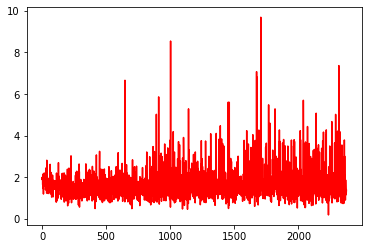

In [ ]:
plt.plot(cost,'r') # Plot the cost over each iteration, maybe consider moving average
plt.xlabel = 'No. Iterations'
plt.show()

[ True  True  True ...  True  True  True]
[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 

100%|██████████| 2376/2376 [05:32<00:00,  7.14it/s]


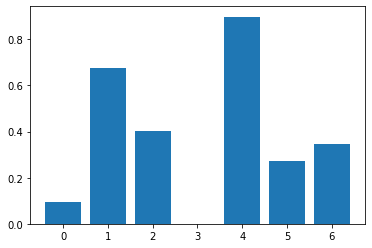

In [ ]:
[f1, f2, w3, w4, b1, b2, b3, b4] = params       # Unload parameters

# get data again, duplicated
X,y = get_img_matrix()
X = np.array(X,dtype=float)  # Needs to be float to do division

X-= int(np.mean(X))   #Making into normal, close to 0
X/= int(np.std(X))

X_train, X_test, y_train, y_test = split(X,np.array(y))
test_data = np.hstack((X_test,y_test.reshape(-1,1)))  #combined

X = test_data[:,0:-1]
X = X.reshape(-1, 3, 28, 28)    #Fit into correct format for filters

y = test_data[:,-1]             #Unflip
print(y==y_test)
ys = [1 if each == 2 or each == 4 or each == 3 else 0 for each in y]
print(ys)
print(y)
corr = 0
count = [0 for i in range(7)]
correct = [0 for i in range(7)]
s,f = 0,0
#print()
print("Computing accuracy over test set:")

t = tqdm(range(len(X)), leave=True)
#t = range(len(X))
for i in t:
    x = X[i]
    pred, prob = predict(x, f1, f2, w3, w4, b1, b2, b3, b4)
    #print(pred,y[i])
    if (pred==2 or pred==5 or pred==3) and (ys[i]==2 or ys[i]==5 or ys[i]==3):
      s +=1
    else:
      if  (not (pred==2 or pred==5 or pred==3)) and (not (ys[i]==2 or ys[i]==5 or ys[i]==3)):
        s +=1

    count[int(y[i])]+=1
    if pred==y[i]:
        corr+=1
        correct[pred]+=1



#print("Overall Accuracy: %.3f" % (float(corr/len(test_data)*100)))
#print("Overall Accuracy 2: %.3f" % (float(s/len(test_data)*100)))
x = np.arange(7)
recall = [x/y for x,y in zip(correct, count)]
plt.xlabel = 'Classes'
plt.ylabel = 'Recall'
plt.title = "Recall on Test Set"
plt.bar(x,recall)
plt.show()

#Need to split 7 cats into 2....



In [ ]:
print("Overall Accuracy: %.3f" % (float(corr/len(test_data)*100)))
print("Overall Accuracy 2: %.3f" % (float(s/len(test_data)*100)))

[f1, f2, w3, w4, b1, b2, b3, b4] = params

#print(repr(params[0]))





Overall Accuracy: 53.535
Overall Accuracy 2: 77.525


In [ ]:
with open('objs.pkl','rb') as f:  # Python 3: open(..., 'rb')
    params2 = pickle.load(f)

In [ ]:
print(len(params2))
print(len(params))

In [ ]:
df = pd.read_csv('Images/out2.csv')

column_names = list(range(1,2353))
column_names.append('label')
df.columns = column_names

print(df['label'][0:10])

X = df.drop(['label'], axis=1)




X1 = np.array(X, dtype='uint8')
print(X1[0].shape)
image = X1[0].reshape(28,28,3)

print(image)
print(image.shape)
#print(X1[0])
#print(type(image[0][0][0]))
print('=====================================')
new_image = np.array(rotation(image),dtype='uint8').reshape(28,28,3)
#print(';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;')

plt.imshow(new_image)
plt.savefig('out.png', bbox_inches='tight', pad_inches=0)



In [ ]:
#x = (np.array([[3,1,7,2],[5,1,0,9],[8,2,4,9],[4,3,1,1]]))
#x = np.zeros((2,3,4))
test_data = np.array([[[2,17], [45, 78]], [[88, 92], [60, 76]],[[76,33],[20,18]]])
print(test_data)
print('')
maxpool(test_data)

[[[ 2 17]
  [45 78]]

 [[88 92]
  [60 76]]

 [[76 33]
  [20 18]]]



array([[[78.]],

       [[92.]],

       [[76.]]])

In [ ]:
from typing import KeysView
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

    def Load():
        driver = self.driver
        driver.get("https://localhost:5000/")
        driver.able('JS',False)
        Keys.send_keys(Keys.RETURN)
        return(driver)






In [ ]:
import pickle


with open('objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(params, f)